In [1]:
import torch
import numpy as np
from utils.generate_csbm import *
from utils.train_helpers import train_NC, train_APPNP, train_pyg_model
from utils.utils import calculate_Atilde
from models.models import MLP
from models.setup import set_up_NC
import networkx as nx
import pickle

train_ids = np.load("experiments/DNC/0.78phi/data/train_ids.npy")
val_ids = np.load("experiments/DNC/0.78phi/data/valid_ids.npy")
test_ids = np.load("experiments//DNC/0.78phi/data/test_ids.npy")

import sys
sys.path.append('utils/')
file_to_open= open("experiments/DNC/0.78phi/data/"+"csbm_"+str(0)+".pickle", "rb")
csbm = pickle.load(file_to_open)
file_to_open.close()


#csbm = cSBM(N=200, p=100, d=6, mu=1, l=2)
#csbm.generate_node_parameters()
#csbm.generate_node_data(n_local=1, method="DNC")
A_tilde = calculate_Atilde(csbm.A, M=10, alpha=0.9)

torch.manual_seed(0)
init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, False)

In [2]:
server = set_up_NC(csbm.Xs, csbm.ys, 
                   init_mlp, A_tilde, 
                   train_ids, val_ids, test_ids,
                   gradient=True,
                   hidden_noise=True, gradient_noise=True,
                   hn_std=10, gn_std=0.1)
tl, ta, vl, va = train_NC(server, 1, batch_size=1, learning_rate=0.1, I=10,
             Print=True, print_time=10)

True True True 10 0.1


In [3]:
a,b,c,d,e,f = train_APPNP(torch.cat(csbm.Xs), torch.cat(csbm.ys), init_mlp, A_tilde, 
                           train_ids, val_ids, test_ids,
                           num_update=10,
                           learning_rate=1, Print=True)

update: 1 Average train loss: 0.68925 Average train accuracy: 0.600 Average val loss: 0.69004 Average val accuracy: 0.700
update: 2 Average train loss: 0.68395 Average train accuracy: 0.750 Average val loss: 0.68868 Average val accuracy: 0.700
update: 3 Average train loss: 0.67848 Average train accuracy: 0.900 Average val loss: 0.68726 Average val accuracy: 0.700
update: 4 Average train loss: 0.67266 Average train accuracy: 0.950 Average val loss: 0.68573 Average val accuracy: 0.700
update: 5 Average train loss: 0.66632 Average train accuracy: 0.950 Average val loss: 0.68412 Average val accuracy: 0.750
update: 6 Average train loss: 0.65930 Average train accuracy: 0.950 Average val loss: 0.68228 Average val accuracy: 0.750
update: 7 Average train loss: 0.65138 Average train accuracy: 0.950 Average val loss: 0.68015 Average val accuracy: 0.750
update: 8 Average train loss: 0.64236 Average train accuracy: 0.950 Average val loss: 0.67779 Average val accuracy: 0.800
update: 9 Average train 

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, APPNP
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, from_scipy_sparse_matrix
import networkx as nx
from scipy import sparse
import torch.optim as optim
import torch.nn.functional as F
class appnp(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dimensions=64, bias=False,
                 K=10, alpha=0.1):
        super().__init__()
        self.appnp_layer = APPNP(K=K, alpha=alpha, cached=True)
        self.linear = nn.Linear(num_node_features, hidden_dimensions, bias=bias)
        self.output = nn.Linear(hidden_dimensions, num_classes, bias=bias)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.linear(x)
        x = F.relu(x)
        x = self.output(self.appnp_layer(x, edge_index))
        return F.log_softmax(x, dim=1) 

In [116]:
init_mlp.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.0007,  0.0536, -0.0823,  ...,  0.0209, -0.0780, -0.0576],
                      [ 0.0941,  0.0674, -0.0436,  ...,  0.0342, -0.0596, -0.0022],
                      [ 0.0042,  0.0645, -0.0756,  ..., -0.0744,  0.0410, -0.0336],
                      ...,
                      [-0.0382,  0.0894, -0.0204,  ..., -0.0817,  0.0320, -0.0344],
                      [ 0.0752, -0.0269, -0.0814,  ..., -0.0688,  0.0960,  0.0056],
                      [ 0.0837,  0.0194, -0.0171,  ...,  0.0880, -0.0844,  0.0626]])),
             ('model.2.weight',
              tensor([[ 0.0365, -0.0507, -0.0367,  0.0213,  0.0265,  0.1061,  0.1194,  0.0072,
                        0.1176, -0.0739,  0.0011, -0.1032,  0.0599,  0.0249, -0.0757, -0.0954,
                       -0.0248, -0.0472, -0.0509, -0.1089, -0.0796,  0.1037, -0.0615,  0.0509,
                        0.0085, -0.0171,  0.0409,  0.0941,  0.0389,  0.0136,  0.1015,  0.0103,
                      

In [121]:
torch.manual_seed(0)
model = appnp(100, 2, 64, True, 10, 0.9)
with torch.no_grad():
    for pname, param in model.named_parameters():
        if pname == "linear.weight":
            param.copy_(init_mlp.state_dict()['model.0.weight'])
        else:
            param.copy_(init_mlp.state_dict()['model.2.weight'])

In [122]:
ei,_ = from_scipy_sparse_matrix(sparse.csr_matrix(csbm.A))

In [123]:
pyg_data = Data(x=torch.cat(csbm.Xs), y=torch.cat(csbm.ys), edge_index=ei)
pyg_data.train_mask=train_ids
pyg_data.val_mask=val_ids
pyg_data.test_mask=test_ids
pyg_data

Data(x=[200, 100], edge_index=[2, 1586], y=[200], train_mask=[20], val_mask=[20], test_mask=[160])

In [124]:
a,b,c,d,e,f = train_pyg_model(pyg_data, 
                model, 
                num_epoch=5000, optimizer=optim.SGD(model.parameters(), lr=0.2), 
                mask=False, Print=False)

TypeError: float() argument must be a string or a number, not 'appnp'

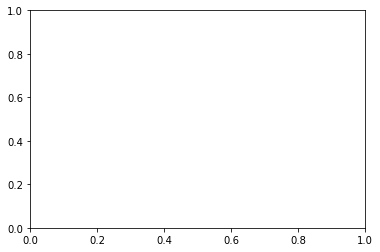

In [131]:
plt.plot(f)

In [109]:
import matplotlib.pyplot as plt

In [132]:
e

0.56875